In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [33]:
cd /content/Sheet5

/content/Sheet5


In [34]:
!unzip robots.zip

Archive:  robots.zip
   creating: robots/
   creating: robots/train/
   creating: robots/train/nrbt/
  inflating: robots/train/nrbt/no_robot_1.jpg  
  inflating: robots/train/nrbt/no_robot_10.jpg  
  inflating: robots/train/nrbt/no_robot_11.jpg  
  inflating: robots/train/nrbt/no_robot_12.jpg  
  inflating: robots/train/nrbt/no_robot_13.jpg  
  inflating: robots/train/nrbt/no_robot_14.jpg  
  inflating: robots/train/nrbt/no_robot_15.jpg  
  inflating: robots/train/nrbt/no_robot_16.jpg  
  inflating: robots/train/nrbt/no_robot_17.jpg  
  inflating: robots/train/nrbt/no_robot_18.jpg  
  inflating: robots/train/nrbt/no_robot_19.jpg  
  inflating: robots/train/nrbt/no_robot_2.jpg  
  inflating: robots/train/nrbt/no_robot_20.jpg  
  inflating: robots/train/nrbt/no_robot_21.jpg  
  inflating: robots/train/nrbt/no_robot_22.jpg  
  inflating: robots/train/nrbt/no_robot_23.jpg  
  inflating: robots/train/nrbt/no_robot_24.jpg  
  inflating: robots/train/nrbt/no_robot_25.jpg  
  inflating: robots

In [46]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from matplotlib.pyplot import figure

In [37]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'robots'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#image_datasets['train'].classes = ['not_robot', 'robot']

class_names = image_datasets['train'].classes

avDev = torch.device("cuda")


In [38]:
dataset_sizes 

{'train': 150, 'val': 50}

In [39]:
class_names

['nrbt', 'rbt']

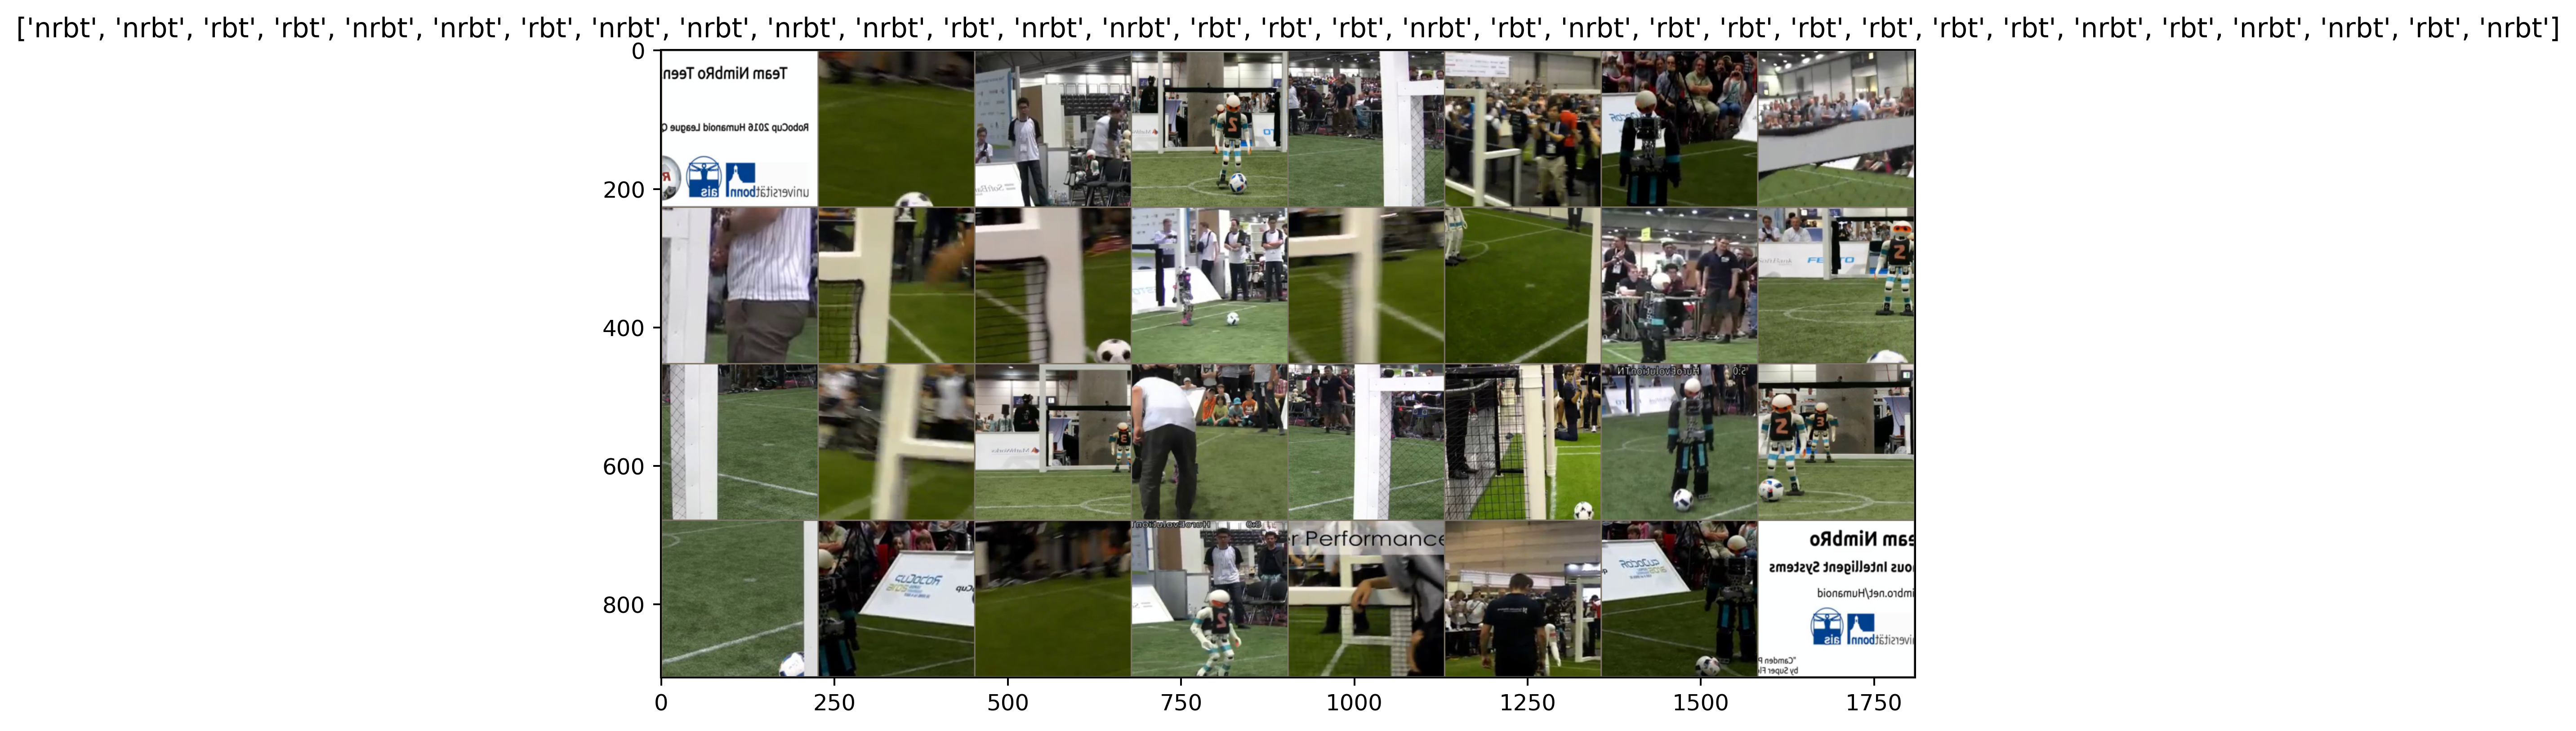

In [48]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    figure(num=None, figsize=(10, 10), dpi=360, facecolor='w', edgecolor='k')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(avDev)
                labels = labels.to(avDev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [42]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        
        inputs, labels = inputs.to(avDev), labels.to(avDev)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu()[j])

            if images_so_far == num_images:
                return

In [43]:
model_ft = models.densenet201(pretrained=True) # check: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [44]:
model_ft = models.densenet201(pretrained=True) # check: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(avDev)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7189 Acc: 0.5667
val Loss: 0.6439 Acc: 0.5600

Epoch 1/24
----------
train Loss: 0.6246 Acc: 0.6267
val Loss: 0.6413 Acc: 0.5800

Epoch 2/24
----------
train Loss: 0.3986 Acc: 0.8600
val Loss: 0.4082 Acc: 0.8600

Epoch 3/24
----------
train Loss: 0.3654 Acc: 0.8867
val Loss: 0.3674 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.3157 Acc: 0.8667
val Loss: 0.4254 Acc: 0.7400

Epoch 5/24
----------
train Loss: 0.2749 Acc: 0.9067
val Loss: 0.3604 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.2356 Acc: 0.9267
val Loss: 0.3090 Acc: 0.8800

Epoch 7/24
----------
train Loss: 0.2568 Acc: 0.9133
val Loss: 0.2683 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.2750 Acc: 0.8800
val Loss: 0.2520 Acc: 0.9200

Epoch 9/24
----------
train Loss: 0.2400 Acc: 0.8867
val Loss: 0.2393 Acc: 0.9200

Epoch 10/24
----------
train Loss: 0.1859 Acc: 0.9267
val Loss: 0.2307 Acc: 0.9400

Epoch 11/24
----------
train Loss: 0.2406 Acc: 0.9333
val Loss: 0.2203 Acc: 0.9400

Epoch 12/24
----------
t